
# Experiments with statistical learning models from NLP on musical corpora

Eamonn Bell <epb2125@columbia.edu> 

February 11, 2016

In [1]:
import pretty_midi
import glob
import numpy as np
import gensim
import music21
import sklearn
import random

from matplotlib import pyplot as plt
%matplotlib inline

from bokeh.plotting import output_file, output_notebook, ColumnDataSource, figure, show
from bokeh.models import HoverTool

from sklearn.manifold import TSNE

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

output_notebook()

Couldn't import dot_parser, loading of dot files will not be possible.


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Loading BokehJS ...

In [2]:
# http://kern.humdrum.org/search?s=t&keyword=Beethoven


# midifns = glob.glob('./corpus/bach/mid/*.mid')
# midifns = glob.glob('./corpus/beethoven/mid/*.mid')
# midifns = glob.glob('./corpus/haydn/mid/*.mid')


# pms = [pretty_midi.PrettyMIDI(fn) for fn in midifns]

In [3]:
def strep_human(w):
    "Create a pretty string representation of the chroma vector from pretty_midi"
    m = { 0 : 'c', 
        1 : 'c+', 
        2 : 'd', 
        3 : 'e-',
        4 : 'e',
        5 : 'f',
        6 : 'f+', 
        7 : 'g', 
        8 : 'a-',
        9 : 'a',
        10 : 'b-',
        11 : 'b'}
    rep = []
    for i, x in enumerate(w):
        if x == 1:
            rep.append(m[i])
    
    return " ".join(rep)

In [4]:
def strep(w):
    "Create a canonical string representation of the chroma vector from pretty_midi"
    return "".join([str(x) for x in w])

In [211]:
docs = []

for pm in pms:
    # Get chroma vector at all note onsets ("salami slicing")
    # A chroma vector in pretty_midi is a 12-place vector which sums 
    # the midi velocity across all octaves of each note
    
    cr = pm.get_chroma(times=pm.get_onsets())
    
    # Transpose to get rep we need. Rows are chroma vectors now
    cr_t = cr.T
    
    # Binarize i.e. set to 1 if entry in chroma vector is non-zero
    # So we don't care about if there are doublingspa (same note name at diff. octaves)
    binarized = np.where(cr_t > 0, 1, 0)
    doc = binarized.tolist()
    doc = [strep(w) for w in doc if sum(w) > 0]
    docs.append(doc)

In [5]:
## Load docs from json

import json

docs = json.load(open('ycac.json'))

In [213]:
dictionary = gensim.corpora.Dictionary(docs)

In [214]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

## Do LDA

In [382]:
lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=24, passes=5, iterations=75)

In [383]:
lda.print_topics(24)

[u'0.155*001000100100 + 0.082*001000010010 + 0.042*100001000100 + 0.039*001001000010 + 0.035*010010000100 + 0.031*101000100100 + 0.025*001000010001 + 0.024*001001000100 + 0.023*100010010000 + 0.021*001010000100',
 u'0.205*100010010000 + 0.153*001000010001 + 0.042*001001010001 + 0.040*001001000100 + 0.031*100001000100 + 0.030*101010010000 + 0.022*001001000001 + 0.021*100011000100 + 0.021*101000010000 + 0.019*000010010001',
 u'0.151*001001000010 + 0.118*000100010010 + 0.064*100100010000 + 0.057*100001000100 + 0.040*001000010010 + 0.039*100101000100 + 0.039*001001001010 + 0.031*100100010010 + 0.028*100100001000 + 0.023*100001001000',
 u'0.169*100010000100 + 0.089*000010001001 + 0.085*100010010000 + 0.059*001000010001 + 0.041*001001000100 + 0.040*000010010001 + 0.036*001010001001 + 0.031*001001000101 + 0.028*100001000100 + 0.027*001001010001',
 u'0.085*100001001000 + 0.084*100100001000 + 0.082*100100010000 + 0.052*000100010010 + 0.049*010001000010 + 0.046*010001001000 + 0.040*001000010001 

## Use a sliding window to track changes in topic over time

If topics (k=24) are roughly equivalent to keys, then changes the topic makeup of subdocuments (windows; sub-pieces) are 'modulations'.

In [10]:
from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [11]:
sliding = []

# pick some random piece and 
for index, subdoc in enumerate(window(docs[15], n=250)):
    topics = dict(lda[dictionary.doc2bow(subdoc)])
    sliding.append(topics)

In [12]:
import pandas as pd
%matplotlib inline

In [13]:
some_movement = pd.DataFrame(sliding)

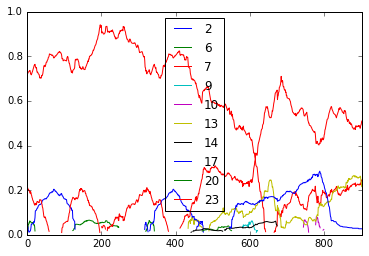

In [239]:
# Should be a stacked bar chart!
some_movement.plot()

---

# Word embedding (word2vec)

## Prep and tSNE dim. rdxn

In [14]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

In [15]:
chunked_docs = []

for doc in docs:
    chunked_docs.extend([x for x in chunks(doc, 32)])

sentences = chunked_docs

model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)

In [16]:
words = model.vocab.keys()
embeddings = np.array([model[w] for w in words])
#tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=200)
#proj = tsne.fit_transform(embeddings)

In [17]:
def myplot(source, title, *args, **kwargs):
    p = figure(title=title)
    p.scatter('x', 'y', line_width=2, source=source, *args, **kwargs)

    tooltips = """ @label """

    hover = HoverTool(tooltips=tooltips)

    p.add_tools(hover)

    try:
        show(p)
    except ImportError:
        # Suppress warning of issue described here 
        # https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/MsizmwbUfw8/7CKPWKrHAAAJ
        pass

In [18]:
# Assemble data 
source = ColumnDataSource(
    data=dict(
        x=proj[:,0],
        y=proj[:,1],
        label=words
    )
)

# Sanity check 
assert len(proj[:,0]) == len(words)

NameError: name 'proj' is not defined

In [ ]:
myplot(source=source, title="tSNE(word2vec) on corpus")

OK, that's nice but a little overwhelming. What about three- and four-note collections only?

In [15]:
# q for query

q_words = [x for x in model.vocab.keys() if 3 <= len(x.split(' ')) <= 4]
q_indices = [words.index(x) for x in q_words]

len(words), len(q_words)

(610, 471)

Eugh, still 471 words... doesn't clear things up that much... Let's plot it anyway.

In [16]:
source = ColumnDataSource(
    data=dict(
        # Use indices to subset np.array
        x=proj[q_indices,0],
        y=proj[q_indices,1],
        label=q_words
    )
)

In [17]:
myplot(source=source, title='tSNE(word2vec) on corpus (3 or 4 note only)')

What about only triads that have a C in?

In [18]:
q_words = [x for x in model.vocab.keys() if (('c ' in x) & (len(x.split(' ')) == 3))]
q_indices = [words.index(x) for x in q_words]

len(words), len(q_words)

(610, 54)

OK, this time it's only 54.

In [19]:
source = ColumnDataSource(
    data=dict(
        # Use indices to subset np.array
        x=proj[q_indices,0],
        y=proj[q_indices,1],
        label=q_words
    )
)

myplot(source=source, title='tSNE(word2vec) on corpus ({C} in w)')

Hypothesis: C minor-ish stuff likely to cluster together. E flat (e-) is what differentiates things.

In [20]:
def group_on_mode(x):
    if 'e ' in x:
        # Majorish
        return 'blue'
    elif 'e-' in x:
        # Minorish
        return 'green'
    else:
        # Don't know
        return 'red'

source = ColumnDataSource(
    data=dict(
        # Use indices to subset np.array
        x=proj[q_indices,0],
        y=proj[q_indices,1],
        mode=[group_on_mode(x) for x in q_words],
        label=q_words
    )
)

myplot(source=source, title='tSNE(word2vec) on corpus ({C} in w)', color='mode')

## What stuff is nearby in word2vec space?

In [21]:
G_MAJOR = 'd g b'
C_MAJOR = 'c e g'
B_FLAT_MAJOR = 'd f b-'
F_MAJOR = 'c f a'

G_DOM_7 = 'd f g b'
B_FLAT_DOM_7 = 'd f a- b-'
F_DOM_7 = 'c e- f a'
D_DOM_7 = 'c d f+ a'

In [22]:
model.most_similar([D_DOM_7])

[('c d f+ g a', 0.9096065163612366),
 ('c d f+ a b', 0.9096042513847351),
 ('c d e f+ a', 0.8769814372062683),
 ('c d e- f+ a', 0.8556093573570251),
 ('c d g a', 0.8442591428756714),
 ('c d f+ a- a', 0.813583254814148),
 ('d g a b', 0.8054274320602417),
 ('d f+ a b-', 0.7629439830780029),
 ('c+ d g b', 0.7142918705940247),
 ('c d f+', 0.6973966956138611)]

## How robust is chord closeness in the word2vec space when we set different sentence lengths?

Coming soon? At the moment I'm setting the sentence length to 64 pretty arbitrarily. This is almost definitely wrong for the `bach` corpus. According to the word-chord analogy, it would seem that a musical 'sentence' is a phrase.

In [254]:
def evaluate_chunk_size(chunk_size):
    chunked_docs = []

    for doc in docs:
        chunked_docs.extend([x for x in chunks(doc, chunk_size)])

    sentences = chunked_docs

    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    top_ten = model.most_similar([G_MAJOR])
    return top_ten

In [255]:
results = []

for _ in range(20):
    chunk_size = random.randint(4, 64)
    results.extend([(chunk_size, i, x[0], x[1]) for i, x in enumerate(evaluate_chunk_size(chunk_size))])

In [256]:
import pandas as pd

In [257]:
results_df = pd.DataFrame(results)
results_df.head(10)

,0,1,2,3
0,61,0,d f+ g b,0.834711
1,61,1,c d g b,0.828530
2,61,2,d g a b,0.800167
3,61,3,d g a- b,0.785234
4,61,4,c+ d g b,0.778229
5,61,5,c d g a,0.741497
6,61,6,d e g b,0.734789
7,61,7,c f+ g b,0.726102
8,61,8,c e- f+ g a,0.725103
9,61,9,d e- g b,0.724425


In [258]:
results_df.columns = ['chunk_size', 'rank', 'nearest_chord', 'similarity']

In [259]:
results_df[results_df['rank'] == 0]

,chunk_size,rank,nearest_chord,similarity
0,61,0,d f+ g b,0.834711
10,54,0,d f+ g b,0.875459
20,53,0,d f+ g b,0.832812
30,33,0,d f+ g b,0.829478
40,52,0,d f+ g b,0.883216
50,12,0,d f+ g b,0.896653
60,52,0,d f+ g b,0.849541
70,54,0,d f+ g b,0.849082
80,34,0,c d g b,0.841546
90,17,0,d f+ g b,0.867853


## Analogical reasoning with word2vec and chords

`man:king :: woman:x`

word2vec solves for `x` and gets `woman` on a natural language corpus.

`trained_model.most_similar(positive=['woman', 'king'], negative=['man'])`

**Hypothesis 1**: The relationship between dominant and tonic in all key is roughly the same. e.g. G major is to C major as B- major is to F major 

e.g.  `{g b d} : {c e g} :: {b- d f} : {f a c}`

In [23]:
model.most_similar(positive=[B_FLAT_MAJOR, C_MAJOR], negative=[G_MAJOR], topn=20)

[('d f g a b-', 0.6601637005805969),
 ('c d f b-', 0.6597018837928772),
 ('d f a b-', 0.6230607628822327),
 ('c+ a b-', 0.6015278100967407),
 ('d f g b-', 0.6004230380058289),
 ('c e- e f', 0.5906780362129211),
 ('f a b-', 0.5831964612007141),
 ('d e b-', 0.5590993762016296),
 ('d f f+ b-', 0.5542265176773071),
 ('c+ d f b-', 0.5537707805633545),
 ('d f b- b', 0.5516623258590698),
 ('c e f+ b-', 0.5507010221481323),
 ('c d b-', 0.5459994077682495),
 ('c a b-', 0.5456947088241577),
 ('c f a b-', 0.533311665058136),
 ('e f g b-', 0.5295522809028625),
 ('g a b-', 0.5192409157752991),
 ('d e- f b-', 0.5142115354537964),
 ('e g a b-', 0.5057578086853027),
 ('f a- a b-', 0.5036612749099731)]

Not much different with the alternative measurement.

In [261]:
model.most_similar_cosmul(positive=[B_FLAT_MAJOR, C_MAJOR], negative=[G_MAJOR], topn=10)

[('f a b-', 1.070783257484436),
 ('f b- b', 1.0369380712509155),
 ('c+ e f', 1.0334950685501099),
 ('d f a b-', 1.002255916595459),
 ('c d f b-', 1.0022058486938477),
 ('d f b- b', 0.9759228825569153),
 ('d f g a b-', 0.9625338912010193),
 ('c+ d f b-', 0.9469479322433472),
 ('d f g b-', 0.9405895471572876),
 ('c f b-', 0.931908369064331)]

**Hypothesis 2**: The relationship between dominant seventh and related tonic in all key is roughly the same. 
    
e.g. G dominant seventh is to C major as B- dominant seventh is to F major 

i.e.  `{g b d f} : {c e g} :: {b- d f a-} : {f a c}`

In [29]:
d1 = model[G_DOM_7] - model[C_MAJOR]
d2 = model[B_FLAT_DOM_7] - model[F_MAJOR]
d3 = model[F_DOM_7] - model[B_FLAT_MAJOR]
d4 = model[D_DOM_7] - model[G_MAJOR]

In [30]:
import scipy

In [31]:
X = [d1, d2, d3, d4]

In [32]:
delta_X = scipy.spatial.distance.pdist(X, 'cosine')

In [33]:
delta_X

array([ 0.73030357,  1.02590648,  1.02473225,  1.21865896,  1.29433468,
        0.82396049])

In [34]:
model.most_similar(positive=[C_MAJOR, F_MAJOR], negative=[B_FLAT_MAJOR], topn=10)

[('c e g a', 0.7149612307548523),
 ('c c+ e g', 0.6812694072723389),
 ('c e f g', 0.667472779750824),
 ('c e g b', 0.6467288136482239),
 ('c d e g', 0.6466063857078552),
 ('c d f b', 0.613850474357605),
 ('c f g a', 0.6117331385612488),
 ('c e f+ g', 0.5948147177696228),
 ('c d b', 0.5840594172477722),
 ('c f b', 0.5806807279586792)]

**Exploration**

In [42]:
focus = [G_MAJOR,
C_MAJOR,
B_FLAT_MAJOR,
F_MAJOR,
G_DOM_7, 
B_FLAT_DOM_7, 
F_DOM_7, 
D_DOM_7]

In [47]:
q_words = [x for x in model.vocab.keys() if x in focus]
q_indices = [words.index(x) for x in q_words]

source = ColumnDataSource(
    data=dict(
        # Use indices to subset np.array
        x=proj[q_indices,0],
        y=proj[q_indices,1],
        label=q_words
    )
)

myplot(source=source, title='tSNE(word2vec) on corpus - interesting subset')

## Systematic examination


### Prepare canonical string representations for Dom7 -> I pairs in all keys

In [73]:
from sklearn.decomposition import PCA

In [52]:
import music21

In [74]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=200)
pca = PCA(n_components=2)

proj = pca.fit_transform(embeddings)

In [66]:
a = music21.chord.Chord(['A', 'C#', 'E'])
b = music21.chord.Chord(['D', 'F#', 'A'])

def transpose_to_all(c):
    out = []
    old = c
    for i in range(12):
        new = old.transpose(7)
        out.append(new)
        old = new
    return out
        
def c_to_strep(c):
    rep = ""
    for i in range(12):
        if i in c.pitchClasses:
            rep += "1"
        else:
            rep += "0"
    return rep

def strep_to_c(strep):
    pcs = []
    for i, v in enumerate(strep):
        if v == '1':
            pcs.append(i)
    return music21.chord.Chord(pcs)       

In [68]:
all_a = [c_to_strep(x) for x in transpose_to_all(a)]
all_b = [c_to_strep(x) for x in transpose_to_all(b)]

pairs = zip(all_a, all_b)
focus = all_a + all_b
q_words = [x for x in model.vocab.keys() if x in focus]
q_indices = [words.index(x) for x in q_words]
x=proj[q_indices,0]
y=proj[q_indices,1]

labels = [" ".join(strep_to_c(w).pitchNames) for w in q_words]

In [76]:
def lookup_strep(strep):
    i = words.index(strep)
    return (proj[i, 0], proj[i, 1])

In [77]:
arrows = [map(lookup_strep, pair) for pair in pairs]

arrow_params = {'length_includes_head': True,
                    'head_starts_at_zero': True}

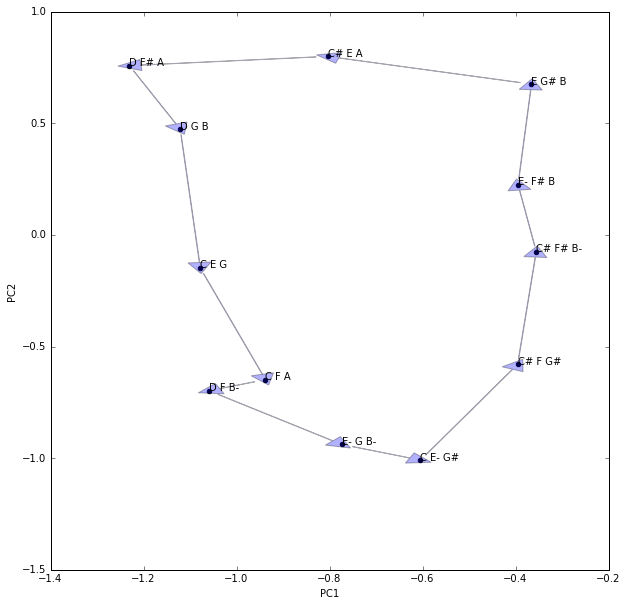

In [78]:
f, ax = plt.subplots()

for lxy in zip(labels, x, y):
    ax.annotate(lxy[0], (lxy[1],lxy[2]))

for arrow in arrows:
    ax.arrow(arrow[0][0], arrow[0][1], arrow[1][0] - arrow[0][0], arrow[1][1] - arrow[0][1], alpha=0.3, 
             linewidth=1, head_width=.05, head_length=.05, **arrow_params)
    
ax.scatter(x, y, c='black')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')